# Catching close encounters using exceptions
Sometimes one is interested in catching a close encounter between two planets. This can easily be done with REBOUND. What you do when a close encounter happens is up to you.

Some integrators are better suited to simulate close encounters than others. For example, the non-symplectic integrator IAS15 has an adaptive timestep scheme that resolves close encounters very well. Integrators that use a fixed timestep like WHFast are more likely to miss close encounters.

Let's start by setting up a two-planet system that will go unstable on a short timescale:

In [1]:
import rebound
import numpy as np
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1.)
    sim.add(m=1e-3,a=1.)
    sim.add(m=5e-3,a=1.25)
    sim.move_to_com()
    return sim

Let's integrate this system for 100 orbital periods.

In [2]:
sim = setupSimulation()
sim.integrate(100.*2.*np.pi)

Rebound exits the integration routine normally. We can now explore the final particle orbits:

In [4]:
for o in sim.orbits():
    print(o)

AttributeError: 'Simulation' object has no attribute 'orbits'

We see that the orbits of both planets changed significantly and we can already speculate that there was a close encounter.

Let's redo the simulation, but this time set the `sim.exit_min_distance` flag for the simulation. If this flag is set, then REBOUND calculates the minimum distance between all particle pairs each timestep. If the distance is less than `sim.exit_min_distance`, then the integration is stopped and an exception thrown. Here, we'll use the [Hill radius](https://en.wikipedia.org/wiki/Hill_sphere) as the criteria for a close encounter. It is given by $r_{\rm Hill} \approx a \sqrt{\frac{m}{3M}}$, which is approximately 0.15 AU in our case. 

This setup allows us to catch the exception and deal with it in a customized way.  As a first example, let's catch the exception with a `try`-`except` block, and simply print out the error message. Additionally, let's store the particles' separations while we're integrating:

In [5]:
sim = setupSimulation() # Resets everything
sim.exit_min_distance = 0.15
Noutputs = 1000
times = np.linspace(0,100.*2.*np.pi,Noutputs)
distances = np.zeros(Noutputs)
ps = sim.particles # ps is now an array of pointers. It will update as the simulation runs.
try:
    for i,time in enumerate(times):
        sim.integrate(time)
        dp = ps[1] - ps[2]   # Calculates the coponentwise difference between particles 
        distances[i] = np.sqrt(dp.x*dp.x+dp.y*dp.y+dp.z*dp.z)
except rebound.Encounter as error:
    print(error)

Two particles had a close encounter (d<exit_min_distance).


The `Encounter` does currently not tell you which particles had a close encounter. But you can easily search for the pair yourself (see below). 

Here, we already know which bodies had a close encounter (the two planets) and we can plot their separation as a function of time.

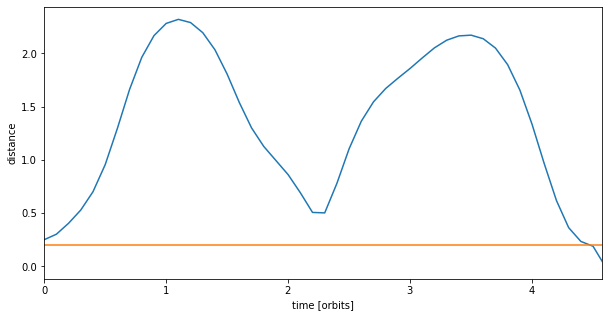

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlabel("time [orbits]")
ax.set_xlim([0,sim.t/(2.*np.pi)])
ax.set_ylabel("distance")
plt.plot(times/(2.*np.pi), distances);
plt.plot([0.0,12],[0.2,0.2]); # Plot our close encounter criteria;

We did indeed find the close encounter correctly. We can now search for the two particles that collided and, for this example, merge them. To do that we'll first calculate our new merged planet coordinates, then remove the two particles that collided from REBOUND and finally add the new particle.

In [7]:
from itertools import combinations
def mergeParticles(sim):
    # Find two closest particles
    min_d2 = 1e9 # large number
    ps = sim.particles
    for i1, i2 in combinations(range(sim.N),2): # get all pairs of indices
        dp = ps[i1] - ps[i2]   # Calculates the coponentwise difference between particles 
        d2 = dp.x*dp.x+dp.y*dp.y+dp.z*dp.z
        if d2<min_d2:
            min_d2 = d2
            col_i1 = i1
            col_i2 = i2
    
    cp1 = ps[col_i1]
    cp2 = ps[col_i2]
    # Merge two closest particles
    
    sum_mass = cp1.m + cp2.m
    mergedPlanet = (cp1*cp1.m + cp2*cp2.m)/sum_mass 
    mergedPlanet.m  = sum_mass
    sim.remove(index=col_i2) # Note: Removing a particle changes the sim.particles
    sim.remove(index=col_i1) #       array and the particle indicies.
    sim.add(mergedPlanet, assignHash=True)

sim = setupSimulation() # Resets everything
sim.exit_min_distance = 0.15
print("Number of particles at the beginning of the simulation: %d."%sim.N)
for i,time in enumerate(times):
    try:
        sim.integrate(time)
    except rebound.Encounter as error:
        print(error)
        mergeParticles(sim)
print("Number of particles at the end of the simulation: %d."%sim.N)

Number of particles at the beginning of the simulation: 3.
Two particles had a close encounter (d<exit_min_distance).
Number of particles at the end of the simulation: 2.


We can achieve the same outcome by using more of the built-in functionality of REBOUND. For that, we set the radius of the particles to their Hill radius. In practice, you might want to use the physical radius, but for this example, we want the collision to occur in a short amount of time and therefore inflate the particle radii. We set the collision detection routine to `direct` which will do a $O(N^2)$ collision search between all particles. The `collisions_resolve` call-back function is set to `merge`, which will merge the particles together, assuming mass and momentum conservation.

In [8]:
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1.)
    sim.add(m=1e-3, a=1., r=np.sqrt(1e-3/3.)) # we now set collision radii!
    sim.add(m=5e-3, a=1.25, r=1.25*np.sqrt(5e-3/3.))
    sim.move_to_com()
    return sim

In [9]:
sim = setupSimulation()
sim.collision = "direct"
sim.collision_resolve = "merge"

print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
sim.integrate(100.)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))

Particles in the simulation at t=   0.0: 3
Particles in the simulation at t= 100.0: 2


We can also use the built-in collision detection and apply our own function to resolve the collision. By default, if we don't set the sim.collision function pointer, `REBOUND` will raise a `Collision` exception when a collision occurs, which we can catch. 

An indirect way of checking which particles collided is to check which ones have a `last_collision` time equal to the current simulation time.

In [10]:
sim = setupSimulation()
sim.collision = "direct"
# we don't set sim.collision_resolve this time

try:
    sim.integrate(100.)
except rebound.Collision:
    collided = []
    for p in sim.particles:
        if p.last_collision == sim.t:
            collided.append(p.index)
    # Custom resolution

print("Particles {0} collided".format(collided))

AttributeError: 'Particle' object has no attribute 'last_collision'